In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot
import scipy.stats as st
import scipy.signal
import scipy.integrate
import pandas
import openpyxl
import json
import math
import timeit

In [74]:
# Amino acid Payzia 35 min, Part 2
#asdf
# name of the measurement batch
batch = "2023_01_19_Testdatensatz"
# name of the acquisitions
acquisitions = [
    'A1_t1_1_Part2',
    'A2_t2_1_Part2',
    'A3_t3_1_Part2',
    'A4_t4_1_Part2',
    'A5_t5_1_Part2',
    'A6_t6_1_Part2',
    'A7_t7_1_Part2',
    'A8_t8_1_Part2',
    'B1_t1_2_Part2',
    'B7_t7_2_Part2',
    'B8_t8_2_Part2',
    'C1_t1_3_Part2',
    'C8_t8_3_Part2',
    'D5_t13_1_Part2',
    'E5_t13_2_Part2',
    'F5_t13_3_Part2'
]
# all information pertaining to XIC extraction, i.e. "time": [t_start, t_end, t_ret], "MS_info": [[precursor m/z, product m/z start, product m/z end, mass trace],...]
user_info = {
    # 'Val55':{
    #     "time": [8, 12, 9.9],
    #     "MS_info": [
    #         [118, 54.95, 55.15, 'M0_m0', True, "2nd"],
    #         [119, 54.95, 55.15, 'M1_m0', True, "2nd"],
    #         [119, 55.95, 56.15, 'M1_m1', True, "2nd"],
    #         [120, 55.95, 56.15, 'M2_m1', True, "2nd"],
    #         [120, 56.95, 57.15, 'M2_m2', True, "2nd"],
    #         [121, 56.95, 57.15, 'M3_m2', True, "2nd"],
    #         [121, 57.95, 58.15, 'M3_m3', True, "2nd"],
    #         [122, 57.95, 58.15, 'M4_m3', False, "2nd"],
    #         [122, 58.95, 59.15, 'M4_m4', False, "2nd"],
    #         [123, 58.95, 59.15, 'M5_m4', False, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Val72':{
    #     "time": [8, 12, 9.9],
    #     "MS_info": [
    #         [118, 71.98, 72.18, 'M0_m0', True, "2nd"],
    #         [119, 71.98, 72.18, 'M1_m0', True, "2nd"],
    #         [119, 72.98, 73.18, 'M1_m1', True, "2nd"],
    #         [120, 72.98, 73.18, 'M2_m1', True, "2nd"],
    #         [120, 73.98, 74.18, 'M2_m2', True, "2nd"],
    #         [121, 73.98, 74.18, 'M3_m2', True, "2nd"],
    #         [121, 74.98, 75.18, 'M3_m3', True, "2nd"],
    #         [122, 74.98, 75.18, 'M4_m3', False, "2nd"],
    #         [122, 75.98, 76.18, 'M4_m4', False, "2nd"],
    #         [123, 75.98, 76.18, 'M5_m4', False, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Orn70':{
    #     "time": [24, 27.5, 25.8],
    #     "MS_info": [
    #         [133, 69.96, 70.16, 'M0_m0'],
    #         [134, 69.96, 70.16, 'M1_m0'],
    #         [134, 70.96, 71.16, 'M1_m1'],
    #         [135, 70.96, 71.16, 'M2_m1'],
    #         [135, 71.96, 72.16, 'M2_m2'],
    #         [136, 71.96, 72.16, 'M3_m2'],
    #         [136, 72.96, 73.16, 'M3_m3'],
    #         [137, 72.96, 73.16, 'M4_m3'],
    #         [137, 73.96, 74.16, 'M4_m4'],
    #         [138, 73.96, 74.16, 'M5_m4']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Pro70':{
    #     "time": [6, 9, 7.8],
    #     "MS_info": [
    #         [116, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [117, 69.96, 70.16, 'M1_m0', False, "1st"],
    #         [117, 70.96, 71.16, 'M1_m1', False, "1st"],
    #         [118, 70.96, 71.16, 'M2_m1', True, "1st"],
    #         [118, 71.96, 72.16, 'M2_m2', True, "1st"],
    #         [119, 71.96, 72.16, 'M3_m2', True, "1st"],
    #         [119, 72.96, 73.16, 'M3_m3', True, "1st"],
    #         [120, 72.96, 73.16, 'M4_m3', True, "1st"],
    #         [120, 73.96, 74.16, 'M4_m4', True, "1st"],
    #         [121, 73.96, 74.16, 'M5_m4', True, "1st"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Met104':{
    #     "time": [4, 7, 5.2],
    #     "MS_info": [
    #         [150, 103.95, 104.15, 'M0_m0', True, "1st"],
    #         [151, 103.95, 104.15, 'M1_m0', True, "1st"],
    #         [151, 104.95, 105.15, 'M1_m1', True, "1st"],
    #         [152, 104.95, 105.15, 'M2_m1', True, "1st"],
    #         [152, 105.95, 106.15, 'M2_m2', True, "1st"],
    #         [153, 105.95, 106.15, 'M3_m2', True, "1st"],
    #         [153, 106.95, 107.15, 'M3_m3', True, "1st"],
    #         [154, 106.95, 107.15, 'M4_m3', False, "1st"],
    #         [154, 107.95, 108.15, 'M4_m4', False, "1st"],
    #         [155, 107.95, 108.15, 'M5_m4', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Met133':{
    #     "time": [4, 7, 5.2],
    #     "MS_info": [
    #         [150, 132.93, 133.13, 'M0_m0', True, "1st"],
    #         [151, 133.93, 134.13, 'M1_m1', True, "1st"],
    #         [152, 134.93, 135.13, 'M2_m2', True, "1st"],
    #         [153, 135.93, 136.13, 'M3_m3', True, "1st"],
    #         [154, 136.93, 137.13, 'M4_m4', False, "1st"],
    #         [155, 137.93, 138.13, 'M5_m5', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    'His110':{
        "time": [24.5, 29, 26.2],
        "MS_info": [
            [156, 109.97, 110.17, 'M0_m0'],
            # [157, 109.97, 110.17, 'M1_m0'],
            # [157, 110.97, 111.17, 'M1_m1'],
            # [158, 110.97, 111.17, 'M2_m1'],
            # [158, 111.97, 112.17, 'M2_m2'],
            # [159, 111.97, 112.17, 'M3_m2'],
            # [159, 112.97, 113.17, 'M3_m3'],
            # [160, 112.97, 113.17, 'M4_m3'],
            # [160, 113.97, 114.17, 'M4_m4'],
            # [161, 113.97, 114.17, 'M5_m4'],
            # [161, 114.97, 115.17, 'M5_m5'],
            # [162, 114.97, 115.17, 'M6_m5']
            ],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Lys84':{
    #     "time": [25.5, 28.5, 26.9],
    #     "MS_info": [
    #         [147, 84.0, 84.2, 'M0_m0', False, "1st"],
    #         [148, 84.0, 84.2, 'M1_m0', False, "1st"],
    #         [148, 85.0, 85.2, 'M1_m1', False, "1st"],
    #         [149, 85.0, 85.2, 'M2_m1', False, "1st"],
    #         [149, 86.0, 86.2, 'M2_m2', False, "1st"],
    #         [150, 86.0, 86.2, 'M3_m2', True, "2nd"],
    #         [150, 87.0, 87.2, 'M3_m3', True, "2nd"],
    #         [151, 87.0, 87.2, 'M4_m3', True, "2nd"],
    #         [151, 88.0, 88.2, 'M4_m4', True, "2nd"],
    #         [152, 88.0, 88.2, 'M5_m4', True, "2nd"],
    #         [152, 89.0, 89.2, 'M5_m5', True, "2nd"],
    #         [153, 89.0, 89.2, 'M6_m5', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Lys130':{
    #     "time": [25.5, 28.5, 26.9],
    #     "MS_info": [
    #         [147, 130.0, 130.2, 'M0_m0', False, "1st"],
    #         [148, 131.0, 131.2, 'M1_m1', False, "1st"],
    #         [149, 132.0, 132.2, 'M2_m2', False, "1st"],
    #         [150, 133.0, 133.2, 'M3_m3', True, "2nd"],
    #         [151, 134.0, 134.2, 'M4_m4', True, "2nd"],
    #         [152, 135.0, 135.2, 'M5_m5', True, "2nd"],
    #         [153, 136.0, 136.2, 'M6_m6', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Arg60':{
    #     "time": [28, 31.5, 29.9],
    #     "MS_info": [
    #         [175, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [176, 69.96, 70.16, 'M1_m0', True, "2nd"],
    #         [176, 70.96, 71.16, 'M1_m1', True, "2nd"],
    #         [177, 69.96, 70.16, 'M2_m0', True, "2nd"],
    #         [177, 70.96, 71.16, 'M2_m1', True, "2nd"],
    #         [178, 69.96, 70.16, 'M3_m0', True, "2nd"],
    #         [178, 70.96, 71.16, 'M3_m1', True, "2nd"],
    #         [179, 69.96, 70.16, 'M4_m0', True, "2nd"],
    #         [179, 70.96, 71.16, 'M4_m1', True, "2nd"],
    #         [180, 69.96, 70.16, 'M5_m0', True, "2nd"],
    #         [180, 70.96, 71.16, 'M5_m1', True, "2nd"],
    #         [181, 70.96, 71.16, 'M6_m1', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Arg70':{
    #     "time": [28, 31.5, 29.9],
    #     "MS_info": [
    #         [175, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [176, 69.96, 70.16, 'M1_m0', True, "2nd"],
    #         [176, 70.96, 71.16, 'M1_m1', True, "2nd"],
    #         [177, 69.96, 70.16, 'M2_m0', True, "2nd"],
    #         [177, 70.96, 71.16, 'M2_m1', True, "2nd"],
    #         [177, 71.96, 72.16, 'M2_m2', True, "2nd"],
    #         [178, 70.96, 71.16, 'M3_m1', True, "2nd"],
    #         [178, 71.96, 72.16, 'M3_m2', True, "2nd"],
    #         [178, 72.96, 73.16, 'M3_m3', True, "2nd"],
    #         [179, 71.96, 72.16, 'M4_m2', True, "2nd"],
    #         [179, 72.96, 73.16, 'M4_m3', True, "2nd"],
    #         [179, 73.96, 74.16, 'M4_m4', True, "2nd"],
    #         [180, 72.96, 73.16, 'M5_m3', True, "2nd"],
    #         [180, 73.96, 74.16, 'M5_m4', True, "2nd"],
    #         [181, 73.96, 74.16, 'M6_m4', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Cit70':{
    #     "time": [7, 10.5, 9.1],
    #     "MS_info": [
    #         [176, 69.96, 70.16, 'M0_m0', True, "1st"],
    #         [177, 69.96, 70.16, 'M1_m0', True, "1st"],
    #         [177, 70.96, 71.16, 'M1_m1', True, "1st"],
    #         [178, 69.96, 70.16, 'M2_m0', True, "1st"],
    #         [178, 70.96, 71.16, 'M2_m1', True, "1st"],
    #         [178, 71.96, 72.16, 'M2_m2', True, "1st"],
    #         [179, 70.96, 71.16, 'M3_m1', True, "1st"],
    #         [179, 71.96, 72.16, 'M3_m2', True, "1st"],
    #         [179, 72.96, 73.16, 'M3_m3', True, "1st"],
    #         [180, 71.96, 72.16, 'M4_m2', True, "1st"],
    #         [180, 72.96, 73.16, 'M4_m3', True, "1st"],
    #         [180, 73.96, 74.16, 'M4_m4', True, "1st"],
    #         [181, 72.96, 73.16, 'M5_m3', True, "1st"],
    #         [181, 73.96, 74.16, 'M5_m4', True, "1st"],
    #         [182, 73.96, 74.16, 'M6_m4', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr182':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 182.0, 182.2, 'M0_m0'],
    #         [183, 183.0, 183.2, 'M1_m1'],
    #         [184, 184.0, 184.2, 'M2_m2'],
    #         [185, 185.0, 185.2, 'M3_m3'],
    #         [186, 186.0, 186.2, 'M4_m4'],
    #         [187, 187.0, 187.2, 'M5_m5'],
    #         [188, 188.0, 188.2, 'M6_m6'],
    #         [189, 189.0, 189.2, 'M7_m7'],
    #         [190, 190.0, 190.2, 'M8_m8'],
    #         [191, 191.0, 191.2, 'M9_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr165':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 164.95, 165.15, 'M0_m0'],
    #         [183, 165.95, 166.15, 'M1_m1'],
    #         [184, 166.95, 167.15, 'M2_m2'],
    #         [185, 167.95, 168.15, 'M3_m3'],
    #         [186, 168.95, 169.15, 'M4_m4'],
    #         [187, 169.95, 170.15, 'M5_m5'],
    #         [188, 170.95, 171.15, 'M6_m6'],
    #         [189, 171.95, 172.15, 'M7_m7'],
    #         [190, 172.95, 173.15, 'M8_m8'],
    #         [191, 173.95, 174.15, 'M9_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr136':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 135.97, 136.17, 'M0_m0'],
    #         [183, 135.97, 136.17, 'M1_m0'],
    #         [183, 136.97, 137.17, 'M1_m1'],
    #         [184, 136.97, 137.17, 'M2_m1'],
    #         [184, 137.97, 138.17, 'M2_m2'],
    #         [185, 137.97, 138.17, 'M3_m2'],
    #         [185, 138.97, 139.17, 'M3_m3'],
    #         [186, 138.97, 139.17, 'M4_m3'],
    #         [186, 139.97, 140.17, 'M4_m4'],
    #         [187, 139.97, 140.17, 'M5_m4'],
    #         [187, 140.97, 141.17, 'M5_m5'],
    #         [188, 140.97, 141.17, 'M6_m5'],
    #         [188, 141.97, 142.17, 'M6_m6'],
    #         [189, 141.97, 142.17, 'M7_m6'],
    #         [189, 142.97, 143.17, 'M7_m7'],
    #         [190, 142.97, 143.17, 'M8_m7'],
    #         [190, 143.97, 144.17, 'M8_m8'],
    #         [191, 143.97, 144.17, 'M9_m8']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Ala44':{
    #     "time": [7, 10, 8.3],
    #     "MS_info": [
    #         [90, 43.9, 44.1, 'M0_m0'],
    #         [91, 43.9, 44.1, 'M1_m0'],
    #         [91, 44.9, 45.1, 'M1_m1'],
    #         [92, 44.9, 45.1, 'M2_m1'],
    #         [92, 45.9, 46.1, 'M2_m2'],
    #         [93, 45.9, 46.1, 'M3_m2']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Gly30':{
    #     "time": [6.5, 9.5, 7.9],
    #     "MS_info": [
    #         [76, 30.0, 30.3, 'M0_m0'],
    #         [77, 30.0, 30.3, 'M1_m0'],
    #         [77, 31.0, 31.3, 'M1_m1'],
    #         [78, 31.0, 31.3, 'M2_m1']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Gly76':{
    #     "time": [6.5, 9.5, 7.9],
    #     "MS_info": [
    #         [76, 30.0, 30.3, 'M0_m0'],
    #         [77, 31.0, 31.3, 'M1_m1'],
    #         [78, 32.0, 32.3, 'M2_m2']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
}

In [51]:
# Amino acid Payzia 35 min, Part 1
# name of the measurement batch
batch = "2023_01_19_Testdatensatz"
# name of the acquisitions
acquisitions = [
    'A1_t1_1_Part1',
    'A2_t2_1_Part1',
    'A3_t3_1_Part1',
    'A4_t4_1_Part1',
    'A5_t5_1_Part1',
    'A6_t6_1_Part1',
    'A7_t7_1_Part1',
    'A8_t8_1_Part1',
    'B1_t1_2_Part1',
    'B7_t7_2_Part1',
    'B8_t8_2_Part1',
    'C1_t1_3_Part1',
    'C8_t8_3_Part1',
    'D5_t13_1_Part1',
    'E5_t13_2_Part1',
    'F5_t13_3_Part1'
]
# all information pertaining to XIC extraction, i.e. "time": [t_start, t_end, t_ret], "MS_info": [[precursor m/z, product m/z start, product m/z end, mass trace],...]
user_info = {
    'Asp74':{
        "time": [2.5, 5.5, 3.8],
        "MS_info": [
            [133, 69.9, 70.1, 'M0_m0'],
            [134, 69.9, 70.1, 'M1_m0'],
            [134, 70.9, 71.1, 'M1_m1'],
            [135, 69.9, 70.1, 'M2_m0'],
            [135, 70.9, 71.1, 'M2_m1'],
            [135, 71.9, 72.1, 'M2_m2'],
            [136, 70.9, 71.1, 'M3_m1'],
            [136, 71.9, 72.1, 'M3_m2'],
            [137, 71.9, 72.1, 'M4_m2']],
        "double_peak": False,
        "duplicate": False,
    },
    'Glu84':{
        "time": [4, 6.4, 5.3],
        "MS_info": [
            [148, 83.9, 84.1, 'M0_m0'],
            [149, 83.9, 84.1, 'M1_m0'],
            [149, 84.9, 85.1, 'M1_m1'],
            [150, 84.9, 85.1, 'M2_m1'],
            [150, 85.9, 86.1, 'M2_m2'],
            [151, 85.9, 86.1, 'M3_m2'],
            [151, 86.9, 87.1, 'M3_m3'],
            [152, 86.9, 87.1, 'M4_m3'],
            [152, 87.9, 88.1, 'M4_m4'],
            [153, 87.9, 88.1, 'M5_m4']],
        "double_peak": False,
        "duplicate": False,
    },
    'Glu130':{
        "time": [4, 6.4, 5.3],
        "MS_info": [
            [148, 129.9, 130.1, 'M0_m0'],
            [149, 130.9, 131.1, 'M1_m1'],
            [150, 131.9, 132.1, 'M2_m2'],
            [151, 132.9, 133.1, 'M3_m3'],
            [152, 133.9, 134.1, 'M4_m4'],
            [153, 134.9, 135.1, 'M5_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Gln84':{
    #     "time": [5.5, 8.5, 6.6],
    #     "MS_info": [
    #         [147, 83.9, 84.1, 'M0_m0'],
    #         [148, 83.9, 84.1, 'M1_m0'],
    #         [148, 84.9, 85.1, 'M1_m1'],
    #         [149, 84.9, 85.1, 'M2_m1'],
    #         [149, 85.9, 86.1, 'M2_m2'],
    #         [150, 85.9, 86.1, 'M3_m2'],
    #         [150, 86.9, 87.1, 'M3_m3'],
    #         [151, 86.9, 87.1, 'M4_m3'],
    #         [151, 87.9, 88.1, 'M4_m4'],
    #         [152, 87.9, 88.1, 'M5_m4']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Gln130':{
    #     "time": [5.5, 8.5, 6.6],
    #     "MS_info": [
    #         [147, 129.9, 130.1, 'M0_m0'],
    #         [148, 130.9, 131.1, 'M1_m1'],
    #         [149, 130.9, 131.1, 'M2_m2'],
    #         [150, 131.9, 132.1, 'M3_m3'],
    #         [151, 132.9, 133.1, 'M4_m4'],
    #         [152, 133.9, 134.1, 'M5_m5']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    'Phe120':{
        "time": [9, 11.5, 10.3],
        "MS_info": [
            [166, 119.9, 120.1, 'M0_m0'],
            [167, 119.9, 120.1, 'M1_m0'],
            [167, 120.9, 121.1, 'M1_m1'],
            [168, 120.9, 121.1, 'M2_m1'],
            [168, 121.9, 122.1, 'M2_m2'],
            [169, 121.9, 122.1, 'M3_m2'],
            [169, 122.9, 123.1, 'M3_m3'],
            [170, 122.9, 123.1, 'M4_m3'],
            [170, 123.9, 124.1, 'M4_m4'],
            [171, 123.9, 124.1, 'M5_m4'],
            [171, 124.9, 125.1, 'M5_m5'],
            [172, 124.9, 125.1, 'M6_m5'],
            [172, 125.9, 126.1, 'M6_m6'],
            [173, 125.9, 126.1, 'M7_m6'],
            [173, 126.9, 127.1, 'M7_m7'],
            [174, 126.9, 127.1, 'M8_m7'],
            [174, 127.9, 128.1, 'M8_m8'],
            [175, 127.9, 128.1, 'M9_m8']],
        "double_peak": False,
        "duplicate": False,
    },
    'Ser60':{
        "time": [4, 7, 5.6],
        "MS_info": [
            [106, 59.94, 60.14, 'M0_m0'], 
            [107, 59.94, 60.14, 'M1_m0'], 
            [107, 60.94, 61.14, 'M1_m1'], 
            [108, 60.94, 61.14, 'M2_m1'], 
            [108, 61.94, 62.14, 'M2_m2'], 
            [109, 61.94, 62.14, 'M3_m2']],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Thr56_Hom56':{
    #     "time": [5, 8.5, 5.9, 6.9],
    #     "MS_info": [
    #         [120, 55.95, 56.15, 'M0_m0'],
    #         [121, 55.95, 56.15, 'M1_m0'],
    #         [121, 56.95, 57.15, 'M1_m1'],
    #         [122, 56.95, 57.15, 'M2_m1'],
    #         [122, 57.95, 58.15, 'M2_m2'],
    #         [123, 57.95, 58.15, 'M3_m2'],
    #         [123, 58.95, 59.15, 'M3_m3'],
    #         [124, 58.95, 59.15, 'M4_m3']],
    #     "double_peak": True,
    #     "duplicate": False,
    # },
    # 'Thr74_Hom74':{
    #     "time": [5, 8.5, 5.9, 6.9],
    #     "MS_info": [
    #         [120, 73.96, 74.16, 'M0_m0'],
    #         [121, 73.96, 74.16, 'M1_m0'],
    #         [121, 74.96, 75.16, 'M1_m1'],
    #         [122, 74.96, 75.16, 'M2_m1'],
    #         [122, 75.96, 76.16, 'M2_m2'],
    #         [123, 75.96, 76.16, 'M3_m2'],
    #         [123, 76.96, 77.16, 'M3_m3'],
    #         [124, 76.96, 77.16, 'M4_m3']],
    #         #TODO: data saving for double peaks; also check if duplicate or not
    #     "double_peak": True,
    #     "duplicate": False,
    # },
    # 'Hom56':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [120, 55.95, 56.15, 'M0_m0'],
    #         [121, 55.95, 56.15, 'M1_m0'],
    #         [121, 56.95, 57.15, 'M1_m1'],
    #         [122, 56.95, 57.15, 'M2_m1'],
    #         [122, 57.95, 58.15, 'M2_m2'],
    #         [123, 57.95, 58.15, 'M3_m2'],
    #         [123, 58.95, 59.15, 'M3_m3'],
    #         [124, 58.95, 59.15, 'M4_m3']],
    #     "double_peak": False,
    # },
    # 'Hom74':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [120, 73.96, 74.16, 'M0_m0'],
    #         [121, 73.96, 74.16, 'M1_m0'],
    #         [121, 74.96, 75.16, 'M1_m1'],
    #         [122, 74.96, 75.16, 'M2_m1'],
    #         [122, 75.96, 76.16, 'M2_m2'],
    #         [123, 75.96, 76.16, 'M3_m2'],
    #         [123, 76.96, 77.16, 'M3_m3'],
    #         [124, 76.96, 77.16, 'M4_m3']],
    #     "double_peak": False,
    # },
    # 'Leu86_Ile86':{
    #     "time": [10, 14, 11.7, 12.5],
    #     "MS_info": [
    #         [132, 86.0, 86.2, 'M0_m0'],
    #         [133, 86.0, 86.2, 'M1_m0'],
    #         [133, 87.0, 87.2, 'M1_m1'],
    #         [134, 87.0, 87.2, 'M2_m1'],
    #         [134, 88.0, 88.2, 'M2_m2'],
    #         [135, 88.0, 88.2, 'M3_m2'],
    #         [135, 89.0, 89.2, 'M3_m3'],
    #         [136, 89.0, 89.2, 'M4_m3'],
    #         [136, 90.0, 90.2, 'M4_m4'],
    #         [137, 90.0, 90.2, 'M5_m4'],
    #         [137, 91.0, 91.2, 'M5_m5'],
    #         [138, 91.0, 91.2, 'M6_m5']],
    #     "double_peak": True,
    #     "duplicate": False,
    # },
    'Ile69':{
        "time": [11, 14, 12.5],
        "MS_info": [
            [132, 68.97, 69.17, 'M0_m0'],
            [133, 68.97, 69.17, 'M1_m0'],
            [133, 69.97, 70.17, 'M1_m1'],
            [134, 69.97, 70.17, 'M2_m1'],
            [134, 70.97, 71.17, 'M2_m2'],
            [135, 70.97, 71.17, 'M3_m2'],
            [135, 71.97, 72.17, 'M3_m3'],
            [136, 71.97, 72.17, 'M4_m3'],
            [136, 72.97, 73.17, 'M4_m4'],
            [137, 72.97, 73.17, 'M5_m4'],
            [137, 73.97, 74.17, 'M5_m5'],
            [138, 73.97, 74.17, 'M6_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Trp146':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [205, 145.96, 146.16, 'M0_m0'],
    #         [206, 145.96, 146.16, 'M1_m0'],
    #         [206, 146.96, 147.16, 'M1_m1'],
    #         [207, 145.96, 146.16, 'M2_m0'],
    #         [207, 146.96, 147.16, 'M2_m1'],
    #         [207, 147.96, 148.16, 'M2_m2'],
    #         [208, 146.96, 147.16, 'M3_m1'],
    #         [208, 147.96, 148.16, 'M3_m2'],
    #         [208, 148.96, 149.16, 'M3_m3'],
    #         [209, 147.96, 148.16, 'M4_m2'],
    #         [209, 148.96, 149.16, 'M4_m3'],
    #         [209, 149.96, 150.16, 'M4_m4'],
    #         [210, 148.96, 149.16, 'M5_m3'],
    #         [210, 149.96, 150.16, 'M5_m4'],
    #         [210, 150.96, 151.16, 'M5_m5'],
    #         [211, 149.96, 150.16, 'M6_m4'],
    #         [211, 150.96, 151.16, 'M6_m5'],
    #         [211, 151.96, 152.16, 'M6_m6'],
    #         [212, 150.96, 151.16, 'M7_m5'],
    #         [212, 151.96, 152.16, 'M7_m6'],
    #         [212, 152.96, 153.16, 'M7_m7'],
    #         [213, 151.96, 152.16, 'M8_m6'],
    #         [213, 152.96, 153.16, 'M8_m7'],
    #         [213, 153.96, 154.16, 'M8_m8'],
    #         [214, 152.96, 153.16, 'M9_m7'],
    #         [214, 153.96, 154.16, 'M9_m8'],
    #         [214, 154.96, 155.16, 'M9_m9'],
    #         [215, 153.96, 154.16, 'M10_m8'],
    #         [215, 154.96, 155.16, 'M10_m9'],
    #         [216, 154.96, 155.16, 'M11_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Trp188':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [205, 187.97, 188.17, 'M0_m0'],
    #         [206, 188.97, 189.17, 'M1_m1'],
    #         [207, 189.97, 190.17, 'M2_m2'],
    #         [208, 190.97, 191.17, 'M3_m3'],
    #         [209, 191.97, 192.17, 'M4_m4'],
    #         [210, 192.97, 193.17, 'M5_m5'],
    #         [211, 193.97, 194.17, 'M6_m6'],
    #         [212, 194.97, 195.17, 'M7_m7'],
    #         [213, 195.97, 196.17, 'M8_m8'],
    #         [214, 196.97, 197.17, 'M9_m9'],
    #         [215, 197.97, 198.17, 'M10_m10'],
    #         [216, 198.97, 199.17, 'M11_m11']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
}

In [52]:
def plot_density(*, ax, x, samples, percentiles=(5, 95), percentile_kwargs=None, **kwargs):
    """
    Method to plot the original data points alongside the posterior predictive plot (percentiles marked with a black, dashed line).
    Serves as a more accurate comparison between data and model than comparing data and posterior distribution.
    """
    assert samples.ndim == 2

    # Step-function mode draws horizontal density bands inbetween the x coordinates
    step_mode = samples.shape[1] == x.shape[0] - 1
    fill_kwargs = {}
    if step_mode:
        samples = np.hstack([
            samples,
            samples[:, -1][:, None]
        ])
        fill_kwargs["step"] = "post"

    # Plot the density band
    pm.gp.util.plot_gp_dist(
        ax=ax,
        x=x,
        samples=samples,
        fill_alpha=1,
        plot_samples=False,
        palette=pyplot.cm.Blues,
        fill_kwargs=fill_kwargs,
        **kwargs
    )

    # Add percentiles for orientation
    pkwargs = dict(
        linestyle="--",
        color="black",
    )
    pkwargs.update(percentile_kwargs or {})
    for p in percentiles:
        values = np.percentile(samples, p, axis=0)
        if step_mode:
            ax.stairs(values[:-1], x, baseline=None, **pkwargs)
        else:
            ax.plot(x, values, **pkwargs)
        pass

    return

#### Test pipeline prototype

In [ ]:
# TODO: add exception for double peaks with regards to data storage, lest summary df will break due to mean, mean[1] etc. -> does not matter for test with His110
# parameters for pre-filtering: is there even a peak?
est_width = 1
# prepare dictionary to save duration of specific sections
time_dict = {"model_building": {}, "sampling": {}, "posterior_predictive_sampling": {}}
# prepare dictionary to save initial guesses for prior parameters
guess_dict = {"slope_guess": {}, "intercept_guess": {}, "noise_width_guess": {}}

# prepare DataFrame for joint peak data report
df_summary = pandas.DataFrame()

for fragment in user_info.keys():
    print(f"Starting with {fragment}")
    # iterate over all mass traces of a fragment
    for masstrace in range(len(user_info[fragment]['MS_info'])):
        print(f"Starting with {user_info[fragment]['MS_info'][masstrace][3]}")
        # iterate over all acquisitions within the batch
        for acquisition in acquisitions:
            # load time and intensity as numpy arrays
            time_np = np.fromfile(fr"C:\Users\niesser\sciebo\Alle Ergebnisse\2023_Hadoop_Test\Peakfitting\230419_Test with ToLas dataset_Part1\{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_time.npy")
            intensity = np.fromfile(fr"C:\Users\niesser\sciebo\Alle Ergebnisse\2023_Hadoop_Test\Peakfitting\230419_Test with ToLas dataset_Part1\{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_intensity.npy")

            # select lowest third of all data points as noise -> noise_tuple
            intensity_tuple = list(enumerate(intensity))
            intensity_tuple.sort(key=lambda x: x[1])
            noise_range = int(np.round(1/3 * len(intensity), decimals=0))
            noise_tuple = intensity_tuple[:noise_range]
            # sort noise_tuple by time, then use the first and last data points for estimating starting values for the priors of noise width and the slope and intercept of baseline
            noise_tuple.sort(key=lambda x: x[0])
            slope_guess = (np.mean([noise_tuple[n][1] for n in range(len(noise_tuple)-5, len(noise_tuple))])-np.mean([noise_tuple[n][1] for n in range(5)]))/(time_np[-1] - time_np[0])
            # calculate y intercept guess from the start of the time window based on the slope_guess
            intercept_guess = np.mean([noise_tuple[n][1] for n in range(5)]) - slope_guess * time_np[0]
            noise_width_guess = np.max([noise_tuple[n][1] for n in range(len(noise_tuple))]) - np.min([noise_tuple[n][1] for n in range(len(noise_tuple))])
            guess_dict["slope_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = slope_guess
            guess_dict["intercept_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = intercept_guess
            guess_dict["noise_width_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = noise_width_guess

            # pre-fit tests for peaks to save computation time (optional)
            # find potential peaks with scipy
            peaks,_ = scipy.signal.find_peaks(intensity)
            peak_candidates = []
            for peak in peaks:
                # test 
                if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
                    peak_candidates.append(peak)
            # in case of a double peak, test second retention time, too
            if user_info[fragment]['double_peak'] == True:
                for peak in peaks:
                    if user_info[fragment]['time'][3] - est_width <= time_np[peak] <= user_info[fragment]['time'][3] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
                        peak_candidates.append(peak)

            if not peak_candidates:
                print(f"For mass trace {fragment}, no valid peak was detected.")
                # add NaN values to summary DataFrame
                df = pandas.DataFrame(
                    {
                    "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                    "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                    "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                    }
                ).transpose()
                df["acquisition"] = 8 * [f"{acquisition}"]
                df["fragment"] = 8 * [f"{fragment}"]
                df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                df_summary = pandas.concat([df_summary,df])
                # plot the data to be able to check if peak detection was correct or not
                fig, ax = pyplot.subplots()
                ax.scatter(time_np, intensity, marker="x", color="black", label="data")
                pyplot.legend()
                ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
                ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
                pyplot.xticks(size=11.5)
                pyplot.yticks(size=11.5)
                pyplot.tight_layout()
                pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_No_Peak.png")
                pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_No_Peak.svg", format="svg")
                continue

            # create model with the above guesses as starting values for priors
            # TODO: double peak und skew berücksichtigen
            start = time.time()
            if user_info[fragment]['double_peak'] == True:
                with pm.Model() as pmodel:
                    # priors
                    if intercept_guess == 0:
                        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
                    else:
                        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, intercept_guess / 2)
                    baseline_slope = pm.Normal("baseline_slope", slope_guess, np.abs(slope_guess*2)+1)
                    baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time_np)
                    if noise_width_guess > 0:
                        noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
                    elif noise_width_guess == 0:
                        noise = pm.LogNormal("noise", np.log(10), 1)
                    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
                    std2 = pm.HalfNormal("std2", np.ptp(time_np) / 3)
                    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
                    height2 = pm.HalfNormal("height2", 0.95 * np.max(intensity))
                    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
                    area2 = pm.Deterministic("area2", height2/(1 / (std2 * np.sqrt(2 * np.pi))))
                    sn = pm.Deterministic("sn", height/noise)
                    sn2 = pm.Deterministic("sn2", height2/noise)
                    mean = pm.Normal("mean", mu=[time_np[0] + np.ptp(time_np) * 1/4, time_np[0] + np.ptp(time_np) * 3/4], sigma=1, transform=pm.distributions.transforms.univariate_ordered)
                    # posterior
                    y = baseline + height * pt.exp(-0.5 * ((time_np - mean[0]) / std)**2) + height2 * pt.exp(-0.5 * ((time_np - mean[1]) / std2)**2)
                    y = pm.Deterministic("y", y)

                    # likelihood
                    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)
            else:
                with pm.Model() as pmodel:
                    # priors plus error handling in case of mathematically impermissible values
                    if intercept_guess == 0:
                        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
                    else:
                        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, intercept_guess / 2)
                    baseline_slope = pm.Normal("baseline_slope", slope_guess, np.abs(slope_guess*2)+1)
                    baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time_np)
                    # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
                    if noise_width_guess > 0:
                        noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
                    elif noise_width_guess == 0:
                        noise = pm.LogNormal("noise", np.log(10), 1)
                    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
                    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
                    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
                    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
                    sn = pm.Deterministic("sn", height/noise)
                    # posterior
                    y = baseline + height * pt.exp(-0.5 * ((time_np - mean) / std)**2)
                    y = pm.Deterministic("y", y)

                    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
                    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)
            time1 = time.time() - start

            # save durations of certain code sections
            time_dict["model_building"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = time1
            time_dict["sampling"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = np.nan
            time_dict["posterior_predictive_sampling"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = np.nan
            
            # sample the model
            start = time.time()
            with pmodel:
                idata = pm.sample_prior_predictive()
                idata.extend(pm.sample(draws=2000, tune=2000))
            time2 = time.time() - start
            time_dict["sampling"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = time2

            # post-fit checks
            # check whether convergence, i.e. r_hat <= 1.05, was not reached OR peak criteria (explanation see next comment) were not met
            if not user_info[fragment]['double_peak'] == True:
                if any(list(az.summary(idata).loc[:,"r_hat"])) > 1.05 or az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2:
                    # decide whether to discard signal or sample with more tune samples based on size of sigma parameter of normal distribution (std) and on the relative sizes of standard deviations of area and heigt
                    if az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2:
                        # post-fit check failed
                        # add NaN values to summary DataFrame
                        df = pandas.DataFrame(
                            {
                            "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            }
                        ).transpose()
                        df["acquisition"] = 8 * [f"{acquisition}"]
                        df["fragment"] = 8 * [f"{fragment}"]
                        df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                        df_summary = pandas.concat([df_summary,df])
                        continue
                    else:
                        # r_hat failed but rest of post-fit check passed
                        # sample again with more tune samples to possibly reach convergence yet
                        with pmodel:
                            idata2 = pm.sample_prior_predictive()
                            idata2.extend(pm.sample(draws=2000, tune=4000))
                        # if still no convergence, kick it
                        if any(list(az.summary(idata2).loc[:,"r_hat"])) > 1.05:
                            # add NaN values to summary DataFrame
                            df = pandas.DataFrame(
                                {
                                "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                }
                            ).transpose()
                            df["acquisition"] = 8 * [f"{acquisition}"]
                            df["fragment"] = 8 * [f"{fragment}"]
                            df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                            df_summary = pandas.concat([df_summary,df])
                            continue
                        # if results still don't meet plausibility/quality criteria, kick it
                        elif az.summary(idata2).loc["std",:]["mean"] <= 0.1 or az.summary(idata2).loc["area",:]["sd"] > az.summary(idata2).loc["area",:]["mean"] * 0.2 or az.summary(idata2).loc["height",:]["sd"] > az.summary(idata2).loc["height",:]["mean"] * 0.2:
                            # add NaN values to summary DataFrame
                            df = pandas.DataFrame(
                                {
                                "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                }
                            ).transpose()
                            df["acquisition"] = 8 * [f"{acquisition}"]
                            df["fragment"] = 8 * [f"{fragment}"]
                            df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                            df_summary = pandas.concat([df_summary,df])
                            continue
                        # if result is improved, accept new inference data and go on
                        else:
                            idata = idata2
            else:
                if any(list(az.summary(idata).loc[:,"r_hat"])) > 1.05 or az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2 or az.summary(idata).loc["std2",:]["mean"] <= 0.1 or az.summary(idata).loc["area2",:]["sd"] > az.summary(idata).loc["area2",:]["mean"] * 0.2 or az.summary(idata).loc["height2",:]["sd"] > az.summary(idata).loc["height2",:]["mean"] * 0.2:
                    # subdivide name of fragment into its two parts
                    fragment1 = fragment.split("_")[0]
                    fragment2 = fragment.split("_")[1]
                    # Booleans to differentiate which peak is or is not detected
                    double_not_found_first = False
                    double_not_found_second = False
                    # decide whether to discard signal or sample with more tune samples based on size of sigma parameter of normal distribution (std) and on the relative sizes of standard deviations of area and heigt
                    if az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2:
                        # post-fit check failed
                        # add NaN values to summary DataFrame
                        df = pandas.DataFrame(
                            {
                            "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            }
                        ).transpose()
                        df["acquisition"] = 8 * [f"{acquisition}"]
                        df["fragment"] = 8 * [f"{fragment1}"]
                        df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                        df_summary = pandas.concat([df_summary,df])
                        double_not_found_first = True
                    if az.summary(idata).loc["std2",:]["mean"] <= 0.1 or az.summary(idata).loc["area2",:]["sd"] > az.summary(idata).loc["area2",:]["mean"] * 0.2 or az.summary(idata).loc["height2",:]["sd"] > az.summary(idata).loc["height2",:]["mean"] * 0.2:
                        # post-fit check failed
                        # add NaN values to summary DataFrame
                        df2 = pandas.DataFrame(
                            {
                            "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                            "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                            }
                        ).transpose()
                        df2["acquisition"] = 8 * [f"{acquisition}"]
                        df2["fragment"] = 8 * [f"{fragment2}"]
                        df2["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                        df_summary = pandas.concat([df_summary,df2])
                        double_not_found_second = True
                    print(f"end of check 1: {fragment}, {acquisition}: {double_not_found_first}, {double_not_found_second}")
                    # if both peaks failed the r_hat and peak criteria tests, then continue
                    if double_not_found_first and double_not_found_second:
                        continue
                    # r_hat failed but rest of post-fit check passed
                    # sample again with more tune samples to possibly reach convergence yet
                    with pmodel:
                        idata2 = pm.sample_prior_predictive()
                        idata2.extend(pm.sample(draws=2000, tune=4000))
                    # if still no convergence, kick it
                    if any(list(az.summary(idata2).loc[:,"r_hat"])) > 1.05:
                        print(f"beginning of check 2: {fragment}, {acquisition}: {double_not_found_first}, {double_not_found_second}")
                        # decide whether to discard signal or sample with more tune samples based on size of sigma parameter of normal distribution (std) and on the relative sizes of standard deviations of area and heigt
                        if not double_not_found_first and az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2:
                            # post-fit check failed
                            # add NaN values to summary DataFrame
                            df = pandas.DataFrame(
                                {
                                "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                }
                            ).transpose()
                            df["acquisition"] = 8 * [f"{acquisition}"]
                            df["fragment"] = 8 * [f"{fragment1}"]
                            df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                            df_summary = pandas.concat([df_summary,df])
                            double_not_found_first = True
                        if not double_not_found_second and az.summary(idata).loc["std2",:]["mean"] <= 0.1 or az.summary(idata).loc["area2",:]["sd"] > az.summary(idata).loc["area2",:]["mean"] * 0.2 or az.summary(idata).loc["height2",:]["sd"] > az.summary(idata).loc["height2",:]["mean"] * 0.2:
                            # post-fit check failed
                            # add NaN values to summary DataFrame
                            df2 = pandas.DataFrame(
                                {
                                "baseline_intercept": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "baseline_slope": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "mean": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "noise": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "std": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "area": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]}, 
                                "height": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                "sn": {"mean": [np.nan], "sd": [np.nan], "hdi_3%": [np.nan], "hdi_97%": [np.nan], "mcse_mean": [np.nan], "mcse_sd": [np.nan], "ess_bulk": [np.nan], "ess_tail": [np.nan], "r_hat": [np.nan]},
                                }
                            ).transpose()
                            df2["acquisition"] = 8 * [f"{acquisition}"]
                            df2["fragment"] = 8 * [f"{fragment2}"]
                            df2["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                            df_summary = pandas.concat([df_summary,df2])
                            double_not_found_second = True
                        # if both peaks failed the r_hat and peak criteria tests, then continue
                        if double_not_found_first and double_not_found_second:
                            continue
                        else:
                            idata = idata2                
                
            # posterior predictive sampling
            start = time.time()
            with pmodel:
                idata.extend(pm.sample_posterior_predictive(idata, return_inferencedata=True))
            time3 = time.time() - start
            time_dict["posterior_predictive_sampling"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = time3

            # save selected parameters for summary DataFrame
            if not user_info[fragment]['double_peak'] == True:
                df = az.summary(idata).loc[["baseline_intercept","baseline_slope", "mean", "noise", "std", "area", "height", "sn"],:]
                df["acquisition"] = 8 * [f"{acquisition}"]
                df["fragment"] = 8 * [f"{fragment}"]
                df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                df_summary = pandas.concat([df_summary,df])
            else:
                print(f"after post-check: {fragment}, {acquisition}: {double_not_found_first}, {double_not_found_second}")
                if not double_not_found_first:
                    df = az.summary(idata).loc[["baseline_intercept", "baseline_slope", "mean[0]", "noise", "std", "area", "height", "sn"],:]
                    df["acquisition"] = 8 * [f"{acquisition}"]
                    df["fragment"] = 8 * [f"{fragment1}"]
                    df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                    df_summary = pandas.concat([df_summary,df])
                if not double_not_found_second:
                    df2 = az.summary(idata).loc[["baseline_intercept", "baseline_slope", "mean[1]", "noise", "std2", "area2", "height2", "sn2"],:]
                    df["acquisition"] = 8 * [f"{acquisition}"]
                    df["fragment"] = 8 * [f"{fragment2}"]
                    df["mass_trace"] = 8 * [f"{user_info[fragment]['MS_info'][masstrace][3]}"]
                    df_summary = pandas.concat([df_summary,df2])

            # save inference data as netcdf
            idata.to_netcdf(fr"./230427_Pipeline_test_Part1/idata_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}")
            # save every single complete summary (to be on the save side -> TODO: possibly remove this later)
            df2 = az.summary(idata)
            df2.to_excel(fr"./230427_Pipeline_test_Part1/idata_summary_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}.xlsx") 

            # save plot of posterior_predictive with 95 % HDI and original data
            fig, ax = pyplot.subplots()
            plot_density(ax=ax, x=time_np, samples=idata.posterior_predictive.L.stack(sample=("chain", "draw")).T.values, percentiles=(2.5,97.5))
            ax.scatter(time_np, intensity, marker="x", color="black", label="data")
            ax.set_xlabel("time / min", fontsize=11.5, fontweight="bold")
            ax.set_ylabel("intensity / a.u.", fontsize=11.5, fontweight="bold")
            pyplot.legend()
            pyplot.tight_layout()
            pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_predictive_posterior.png")
            pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_predictive_posterior.svg", format="svg")
            pyplot.close()

            # save plot of posterior, baseline, and original data
            fig, ax = pyplot.subplots()
            pm.gp.util.plot_gp_dist(
                ax=ax,
                x=time_np,
                samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
            )
            ax.scatter(time_np, intensity, marker="x", color="black", label="data")
            # also plot the baseline
            x = np.array(ax.get_xlim())
            y = df.loc["baseline_intercept","mean"] + df.loc["baseline_slope","mean"] * x
            pyplot.plot(x, y)
            pyplot.legend()
            ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
            ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
            pyplot.xticks(size=11.5)
            pyplot.yticks(size=11.5)
            pyplot.tight_layout()
            pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_posterior.png")
            pyplot.savefig(fr"./230427_Pipeline_test_Part1/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_posterior.svg", format="svg")
            pyplot.close()          
            
time_df = pandas.DataFrame(time_dict)
time_df.to_excel(fr"./230427_Pipeline_test_Part1/summary_time.xlsx")
guess_df = pandas.DataFrame(guess_dict)
guess_df.to_excel(fr"./230427_Pipeline_test_Part1/summary_guesses.xlsx")
# summary file for peak characteristics of all fragments
# df_summary = df_summary.rename({"Unnamed: 0": "parameter"}, axis=1)
df_summary.to_excel(fr"./230427_Pipeline_test_Part1/summary_peak_data.xlsx")
# also save a version of df_summary only for areas with correct order and only necessary data
df_area_summary = df_summary[df_summary.index == "area"]
df4_area_summary = df_area_summary.sort_values(["acquisition", "mass_trace"])
df4_area_summary = df4_area_summary.drop(labels=["mcse_mean", "mcse_sd", "ess_bulk", "ess_tail"], axis=1)
# df4_area_summary = df4_area_summary.rename({"Unnamed: 0": "parameter"}, axis=1)
df4_area_summary.to_excel(fr"./230427_Pipeline_test_Part1/summary_peak_area.xlsx")

In [50]:
# df_area_summary = df_summary[df_summary.iloc[:,1] == "area"]
df = df_summary[df_summary.index == "area"]
df2 = df
df2 = pandas.concat([df2,df])
df2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,acquisition,fragment,mass_trace
area,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],A2_t2_1_Part1,Leu86,M0_m0
area,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],A2_t2_1_Part1,Ile86,M0_m0
area,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],A2_t2_1_Part1,Leu86,M0_m0
area,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],A2_t2_1_Part1,Ile86,M0_m0


#### Test model with skew normal distribution (exmaple: His110)

In [78]:
# Read example data
time_np = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_intensity.npy")

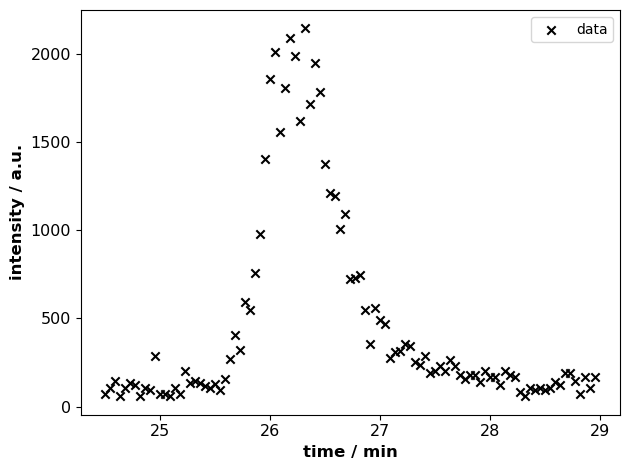

In [79]:
fig, ax = pyplot.subplots()
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
pyplot.legend()
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.xticks(size=11.5)
pyplot.yticks(size=11.5)
pyplot.tight_layout()
pyplot.show()

neues Modell -> erzeugt guten Fit, aber Höhe ist definitiv falsch

In [94]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = 0
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    # y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    # normal_pdf = (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    # cumulative_distribution_function = (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))

    # y = baseline + area * pdf(skew normal)
    # pdf(skew normal) = 2 * normal_pdf *cumulative_distribution_function
    # y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))
    y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))

    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

neues Modell -> Versuch zur Korrektur der Höhe: Annahme: Höhe ist f(time - mean = 0)

In [ ]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [ ]:
with pm.Model() as pmodel:
    # priors plus error handling in case of mathematically impermissible values
    if intercept_guess == 0:
        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
    else:
        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, intercept_guess / 2)
    baseline_slope = pm.Normal("baseline_slope", slope_guess, np.abs(slope_guess*2)+1)
    baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time_np)
    # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
    if noise_width_guess > 0:
        noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
    elif noise_width_guess == 0:
        noise = pm.LogNormal("noise", np.log(10), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    sn = pm.Deterministic("sn", height/noise)
    # posterior
    y = baseline + height * pt.exp(-0.5 * ((time_np - mean) / std)**2)
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

In [ ]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    height = pm.HalfNormal("height", 0.95 * np.max(intensity_np))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    sn = pm.Deterministic("sn", height/noise)
    # posterior with x = time = 0
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [95]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(2000, tune = 2000))

Sampling: [L, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.


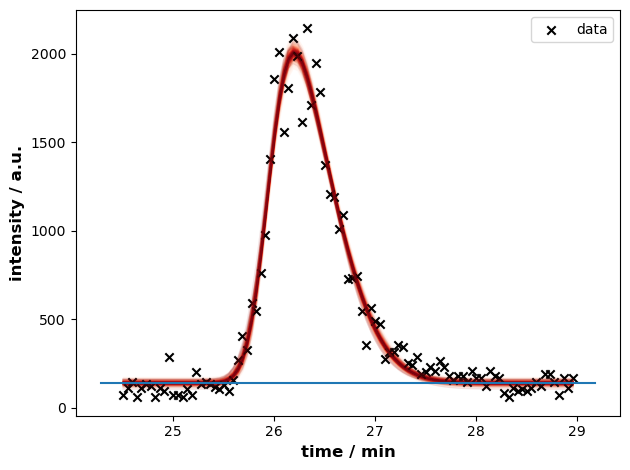

In [82]:
# area
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata).loc["baseline","mean"]
y = [y_baseline] * len(x)
pyplot.plot(x, y)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [87]:
# skew normal
az.summary(idata).loc["area","mean"]

1495.784

In [96]:
# skew normal with alpha = 0
az.summary(idata).loc[["area","height"],"mean"]

area      1433.825
height    1841.238
Name: mean, dtype: float64

In [93]:
# normal
az.summary(idata).loc[["area","height"],"mean"]

area      1434.721
height    1841.643
Name: mean, dtype: float64

In [ ]:
rv = pm.SkewNormal.dist(...)
pdf = pt.exp(pm.logp(rv, x))

In [86]:
help(pm.SkewNormal.dist)

Help on method dist in module pymc.distributions.continuous:

dist(alpha=1, mu=0.0, sigma=None, tau=None, *args, **kwargs) method of pymc.distributions.distribution.DistributionMeta instance
    Creates a tensor variable corresponding to the `cls` distribution.
    
    Parameters
    ----------
    dist_params : array-like
        The inputs to the `RandomVariable` `Op`.
    shape : int, tuple, Variable, optional
        A tuple of sizes for each dimension of the new RV.
    **kwargs
        Keyword arguments that will be forwarded to the PyTensor RV Op.
        Most prominently: ``size`` or ``dtype``.
    
    Returns
    -------
    rv : TensorVariable
        The created random variable tensor.



In [ ]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

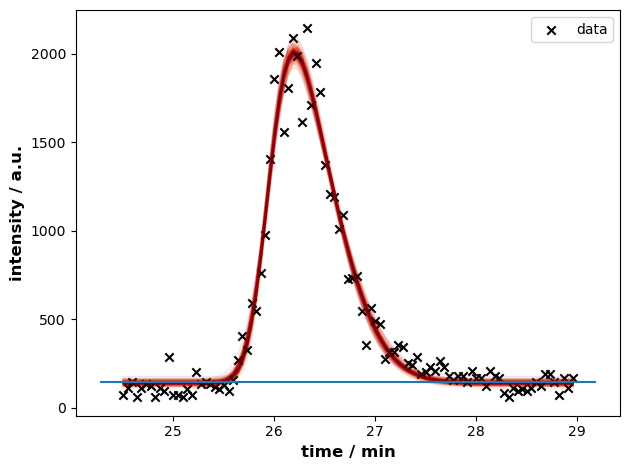

In [ ]:
# height
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata).loc["baseline","mean"]
y = [y_baseline] * len(x)
pyplot.plot(x, y)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [ ]:
az.summary(idata).loc["height","mean"]

1140.687

#### Zeit verschiedener Methoden zum Guesses von baseline priors messen

In [56]:
def initial_guesses(time, intensity):
    """
    Provide initial guesses for priors.

    Parameters
    ----------
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe

    Returns
    -------
    baseline_fit.slope : float or int
        guess for the slope of the linear baseline prior
    baseline_fit.intercept : float or int
        guess for the intercept of the linear baseline prior
    noise_width_guess : float or int
        guess for the width of the noise
    """
    # first create a simple baseline guess only to be able to "correct" the intensity data (y_corrected = y - y_baseline)
    # then, use the corrected data to determine which data points are going to be defined as noise
    # this is the only use of the corrected data
    average_initial_intensity = np.mean([intensity[n] for n in range(3)])
    average_final_intensity = np.mean(
        [intensity[n] for n in range(len(intensity) - 3, len(intensity))]
    )
    slope_guess = (average_final_intensity - average_initial_intensity) / (time[-1] - time[0])
    # calculate intercept_guess based on the slope_guess and the formula for a linear equation
    first_intercept_guess = average_initial_intensity - slope_guess * time[0]
    intensity_corrected = [
        intensity[n] - (slope_guess * time[n] + first_intercept_guess) for n in range(len(time))
    ]

    # select lowest 35 % of all data points as noise -> noise_tuple
    intensity_tuple = list(enumerate(intensity_corrected))
    intensity_tuple.sort(key=lambda x: x[1])
    noise_range = int(np.round(0.35 * len(intensity_corrected), decimals=0))
    noise_tuple = intensity_tuple[:noise_range]
    noise_index = sorted([x[0] for x in noise_tuple])
    # use the indeces in noise_index to get the time and intensity of all noise data points
    noise_time = [time[n] for n in noise_index]
    noise_intensity = [intensity[n] for n in noise_index]
    # calculate the width of the noise
    noise_width_guess = max(noise_intensity) - min(noise_intensity)

    # use scipy to fit a linear regression through the noise as a prior for the eventual baseline
    baseline_fit = st.linregress(noise_time, noise_intensity)

    return baseline_fit.slope, baseline_fit.intercept, noise_width_guess

In [57]:
def initial_guesses_numpy(time, intensity):
    """
    Provide initial guesses for priors.

    Parameters
    ----------
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe

    Returns
    -------
    baseline_fit.slope : float or int
        guess for the slope of the linear baseline prior
    baseline_fit.intercept : float or int
        guess for the intercept of the linear baseline prior
    noise_width_guess : float or int
        guess for the width of the noise
    """
    # first create a simple baseline guess only to be able to "correct" the intensity data (y_corrected = y - y_baseline)
    # then, use the corrected data to determine which data points are going to be defined as noise
    # this is the only use of the corrected data
    time = np.asanyarray(time)
    intensity = np.asanyarray(intensity)
    average_initial_intensity = np.mean(intensity[:3])
    average_final_intensity = np.mean(intensity[-3:])
    slope_guess = (average_final_intensity - average_initial_intensity) / np.ptp(time)
    # calculate intercept_guess based on the slope_guess and the formula for a linear equation
    first_intercept_guess = average_initial_intensity - slope_guess * time[0]
    intensity_corrected = [
        intensity[n] - (slope_guess * time[n] + first_intercept_guess) for n in range(len(time))
    ]

    # select lowest 35 % of all data points as noise -> noise_tuple
    intensity_tuple = list(enumerate(intensity_corrected))
    intensity_tuple.sort(key=lambda x: x[1])
    noise_range = int(np.round(0.35 * len(intensity_corrected), decimals=0))
    noise_tuple = intensity_tuple[:noise_range]
    noise_index = sorted([x[0] for x in noise_tuple])
    # use the indeces in noise_index to get the time and intensity of all noise data points
    noise_time = time[noise_index]
    noise_intensity = intensity[noise_index]
    # calculate the width of the noise
    noise_width_guess = np.ptp(noise_intensity)

    # use scipy to fit a linear regression through the noise as a prior for the eventual baseline
    baseline_fit = st.linregress(noise_time, noise_intensity)

    # return baseline_fit.slope, baseline_fit.intercept, noise_width_guess
    return baseline_fit.slope, baseline_fit.intercept, noise_width_guess

In [2]:
6/0.35

17.142857142857142

In [5]:
intensity = [1,5,3] + 11 * [1000] + [7,9,11]
len(intensity)

17

In [12]:
time = [2+0.1*x for x in range(17)]
len(time)

17

In [13]:
expected_noise_width = np.ptp([1,5,3,7,9,11])
expected_noise_width

10

In [14]:
st.linregress(time, intensity)

LinregressResult(slope=3.2352941176469847, intercept=640.1176470588236, rvalue=0.003336614214125531, pvalue=0.9898597583919873, stderr=250.35699232556948, intercept_stderr=711.6482830295781)

In [58]:
# Read example data
time = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_time.npy")
intensity = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_intensity.npy")

In [62]:
%timeit -n 20000 slope2, intercept2, noise2 = initial_guesses(time, intensity)

259 µs ± 9.03 µs per loop (mean ± std. dev. of 7 runs, 20,000 loops each)


In [63]:
%timeit -n 20000 slope1, intercept1, noise1 = initial_guesses_numpy(time, intensity)

267 µs ± 8.51 µs per loop (mean ± std. dev. of 7 runs, 20,000 loops each)


In [40]:
slope1, intercept1, noise1 = initial_guesses_numpy(time, intensity)
slope2, intercept2, noise2 = initial_guesses(time, intensity)
assert slope1 == slope2
assert intercept1 == intercept2
assert noise1 == noise2

In [53]:
testcode1 = """
slope2, intercept2, noise2 = initial_guesses(time, intensity)
"""

In [54]:
testcode2 = """
slope1, intercept1, noise1 = initial_guesses_numpy(time, intensity)
"""

In [16]:
indexes, times = initial_guesses_numpy(time, intensity)
print(indexes, times)

[0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 72, 75, 79, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 97, 98] [24.50585    24.55131667 24.64223333 24.68768333 24.7786     24.82406667
 24.86953333 24.91498333 25.0059     25.05136667 25.09681667 25.14228333
 25.18773333 25.27866667 25.36958333 25.41503333 25.4605     25.50595
 25.55141667 27.77891667 27.9153     28.09713333 28.27896667 28.32443333
 28.36988333 28.41535    28.4608     28.50626667 28.55171667 28.59718333
 28.64263333 28.77901667 28.82448333 28.9154     28.96085   ]


In [22]:
_,_,_,formertimes = initial_guesses(time, intensity)
assert np.asarray(formertimes).all() == np.asarray(times).all()

In [14]:
testarray = np.asarray([1,2,3])
testarray[[1,2]]

array([2, 3])

In [28]:
asf = [1,2,3,4,5,6]
asf = np.asarray(asf)
asf[-3:]

array([4, 5, 6])

In [31]:
np.ptp(asf)

5

In [36]:
list(enumerate(asf))

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

In [59]:
timeit.timeit(stmt=testcode1, number=1000)

NameError: name 'initial_guesses' is not defined